#  referred paper
Generating Discrete Patient Records

# install old version

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==1.13.2

Found existing installation: tensorflow 1.13.2
Uninstalling tensorflow-1.13.2:
  Would remove:
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-1.13.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/uninstall.py", line 86, in run
    auto_confirm=options.yes, verbose=self.verbosity > 0,
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_install.py", line 658, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/

# mount drive

In [ ]:
import os
from PIL import Image

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive')

# clone

In [ ]:
!git clone https://github.com/mp2893/medgan.git

Cloning into 'medgan'...
remote: Enumerating objects: 68, done.
remote: Total 68 (delta 0), reused 0 (delta 0), pack-reused 68
Unpacking objects: 100% (68/68), done.


In [ ]:
os.chdir('/content/drive/MyDrive/medgan')

# preparing data

In [ ]:
import sys
import _pickle as pickle
import numpy as np
from datetime import datetime

In [ ]:
def convert_to_icd9(dxStr):
    if dxStr.startswith('E'):
        if len(dxStr) > 4: return dxStr[:4] + '.' + dxStr[4:]
        else: return dxStr
    else:
        if len(dxStr) > 3: return dxStr[:3] + '.' + dxStr[3:]
        else: return dxStr

def convert_to_3digit_icd9(dxStr):
    if dxStr.startswith('E'):
        if len(dxStr) > 4: return dxStr[:4]
        else: return dxStr
    else:
        if len(dxStr) > 3: return dxStr[:3]
        else: return dxStr

In [ ]:
# input arguments
binary_count = 'binary'

if binary_count == 'count':
  base_dir = 'GOSH/count/'
else:
  base_dir = 'GOSH/binary/'

raw_data_dir = 'GOSH/raw_data/'
processed_data_dir = base_dir + 'processed_mimic/'
model_dir = base_dir + 'models/'
gen_data_dir = base_dir + 'generated_data/'

In [ ]:
admissionFile = raw_data_dir + 'ADMISSIONS.csv'
diagnosisFile = raw_data_dir + 'DIAGNOSES_ICD.csv'
outFile = processed_data_dir + 'processed_mimic'

In [ ]:
if binary_count != 'binary' and binary_count != 'count':
    print('You must choose either binary or count.')

In [ ]:
print('Building pid-admission mapping, admission-date mapping')
pidAdmMap = {}
admDateMap = {}
infd = open(admissionFile, 'r')
infd.readline()
for line in infd:
    tokens = line.strip().split(',')
    pid = int(tokens[1])
    admId = int(tokens[2])
    admTime = datetime.strptime(tokens[3], '%Y-%m-%d %H:%M:%S')
    admDateMap[admId] = admTime
    if pid in pidAdmMap: pidAdmMap[pid].append(admId)
    else: pidAdmMap[pid] = [admId]
infd.close()

print('Building admission-dxList mapping')
admDxMap = {}
infd = open(diagnosisFile, 'r')
infd.readline()
for line in infd:
    tokens = line.strip().split(',')
    admId = int(tokens[2])
    # Uncomment this line and comment the line below, if you want to use the entire ICD9 digits.
    dxStr = 'D_' + convert_to_icd9(tokens[4][1:-1])
    #dxStr = 'D_' + convert_to_3digit_icd9(tokens[4][1:-1])
    if admId in admDxMap: admDxMap[admId].append(dxStr)
    else: admDxMap[admId] = [dxStr]
infd.close()

print('Building pid-sortedVisits mapping')
pidSeqMap = {}
for pid, admIdList in pidAdmMap.items():
    #if len(admIdList) < 2: continue
    sortedList = sorted([(admDateMap[admId], admDxMap[admId]) for admId in admIdList])
    pidSeqMap[pid] = sortedList

print('Building pids, dates, strSeqs')
pids = []
dates = []
seqs = []
for pid, visits in pidSeqMap.items():
    pids.append(pid)
    seq = []
    date = []
    for visit in visits:
        date.append(visit[0])
        seq.append(visit[1])
    dates.append(date)
    seqs.append(seq)

print('Converting strSeqs to intSeqs, and making types')
types = {}
newSeqs = []
for patient in seqs:
    newPatient = []
    for visit in patient:
        newVisit = []
        for code in visit:
            if code in types:
                newVisit.append(types[code])
            else:
                types[code] = len(types)
                newVisit.append(types[code])
        newPatient.append(newVisit)
    newSeqs.append(newPatient)

print('Constructing the matrix')
numPatients = len(newSeqs)
numCodes = len(types)
matrix = np.zeros((numPatients, numCodes)).astype('float32')
for i, patient in enumerate(newSeqs):
    for visit in patient:
        for code in visit:
            if binary_count == 'binary':
                matrix[i][code] = 1.
            else:
                matrix[i][code] += 1.

pickle.dump(pids, open(outFile+'.pids', 'wb'), -1)
pickle.dump(matrix, open(outFile+'.matrix', 'wb'), -1)
pickle.dump(types, open(outFile+'.types', 'wb'), -1)

Building pid-admission mapping, admission-date mapping
Building admission-dxList mapping
Building pid-sortedVisits mapping
Building pids, dates, strSeqs
Converting strSeqs to intSeqs, and making types
Constructing the matrix


# Add Lasso Regularization

we try to implement Lasso Regularization. Based on GANs notion of zero-sum game setting for two players, the problem between generator _G_ and discriminator _D_. the formula can be written as follows:

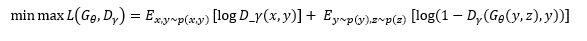

Lasso regularization, also known as L1 regularization, adds magnitude of coefficient as penalty term to the loss function. it can be written as follows:

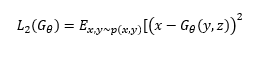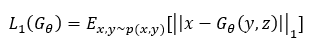

Thus, with addition in optimization equation, we write this as follows:

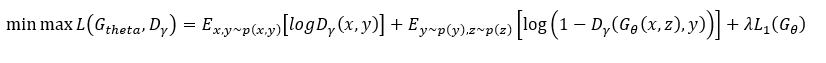

train model

In [ ]:
from medgan import Medgan

medgan = Medgan()
medgan.train(dataPath='/content/drive/MyDrive/medgan/GOSH/binary/processed_mimic/processed_mimic.matrix',
             modelPath='',
              outPath='out',
              nEpochs=500,
              discriminatorTrainPeriod=2,
              generatorTrainPeriod=1,
              pretrainBatchSize=100,
              batchSize=1000,
              pretrainEpochs=100,
              saveMaxKeep=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Pretrain_Epoch:0, trainLoss:nan, validLoss:nan, validReverseLoss:0.000000
Pretrain_Epoch:1, trainLoss:nan, validLoss:nan, validReverseLoss:0.000000
Pretrain_Epoch:2, trainLoss:nan, validLoss:nan, validReverseLoss:0.000000
Pretrain_Epoch:3, trainLoss:nan, validLoss:nan, validReverseLoss:0.000000
Pretrain_Epoch:4, trainLoss:nan, validLoss:nan, validReverseLoss:0.000000
Pretrain_Epoch:5, trainLoss:nan, validLoss:nan, validReverseLoss:0.000000
Pretrain_Epoch:6, trainLoss:nan, validLoss:nan, validReverseLoss:0.000000
Pretrain_Epoch:7, trainLoss:nan, validLoss:nan, validReverseLoss:0.000000
Pretrain_Epoch:8, trainLoss:nan, validLoss:nan, validReverseLoss:0.000000
Pretrain_Epoch:9, trainLoss:nan, validLoss:nan, validReverseLoss:0.000000
Pretrain_Epoch:10, trainLoss:nan, validLoss:nan, validReverseLoss:0.000000
Pretrain_Epoch:11, trainLoss:nan, validLoss:nan, validReverseLoss:0.000000
Pretrain_Epoch:12, trainLoss:nan, validLoss:nan, validReverseLoss:0.000000
Pretrain_Epoch:13, trainLoss:nan, v

ValueError: ignored

however, I'm deeply sorry that I still have issue when training model in this case.